In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

In [2]:
import torch

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
real_estate = pd.read_excel("./Real estate valuation data set.xlsx",index_col=0)
real_estate.shape

(414, 7)

In [5]:
real_estate.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
No,,,,,,,
1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [6]:
real_estate.isna().sum()

X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

## Regression with 2 variables
### Create simple regression model to get point estimate of regr params and benchmark bayes regression

In [7]:
x_cols = [x for x in real_estate.columns if "Y house" not in x]
x_cols

['X1 transaction date',
 'X2 house age',
 'X3 distance to the nearest MRT station',
 'X4 number of convenience stores',
 'X5 latitude',
 'X6 longitude']

In [8]:
X = real_estate[x_cols]
y = np.log(real_estate["Y house price of unit area"])

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))

0.6857555498788217


In [9]:
reg.intercept_,reg.coef_

(-511.72152894322306,
 array([ 1.35497358e-01, -6.96718545e-03, -1.45489935e-04,  2.77486433e-02,
         7.92481130e+00,  3.68660099e-01]))

In [10]:
np.sum((y-reg.predict(X))**2)

19.991029652339122

## Bayes Regression with pyro

In [11]:
X.shape,y.shape

((414, 6), (414,))

In [12]:
from svi_diagonal import ashish_bayes_regr
linear_reg_model,x_data,y_data = ashish_bayes_regr(X,y,NUM_ITER=30000)

fit = real_estate.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

Fitting Bayes Regression
[iteration 0300] loss: 181.4541
[iteration 0600] loss: 27.1492
[iteration 0900] loss: 24.3564
[iteration 1200] loss: 23.7317
[iteration 1500] loss: 23.6467
[iteration 1800] loss: 23.6399
[iteration 2100] loss: 23.6396
[iteration 2400] loss: 23.6395
[iteration 2700] loss: 23.6394
[iteration 3000] loss: 23.6394
[iteration 3300] loss: 23.6393
[iteration 3600] loss: 23.6410
[iteration 3900] loss: 24.5394
[iteration 4200] loss: 85.7621
[iteration 4500] loss: 2688.0449
[iteration 4800] loss: 23.6394
[iteration 5100] loss: 23.6389
[iteration 5400] loss: 23.6390
[iteration 5700] loss: 23.6930
[iteration 6000] loss: 36.1296
[iteration 6300] loss: 1749.0276
[iteration 6600] loss: 1701.2402
[iteration 6900] loss: 23.6385
[iteration 7200] loss: 23.6384
[iteration 7500] loss: 23.6388
[iteration 7800] loss: 25.0328
[iteration 8100] loss: 875.3271
[iteration 8400] loss: 14106.9580
[iteration 8700] loss: 23.6381
[iteration 9000] loss: 23.6380
[iteration 9300] loss: 23.6380
[it

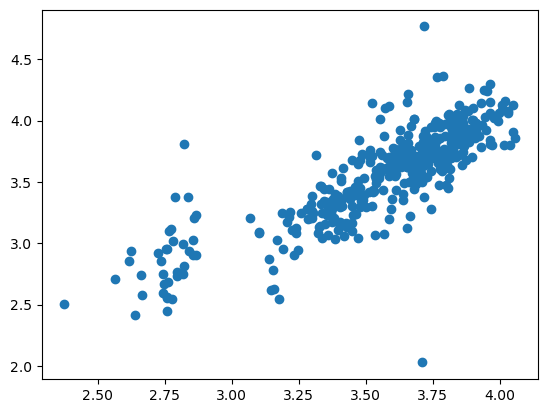

In [13]:
plt.scatter(reg.predict(X),y)

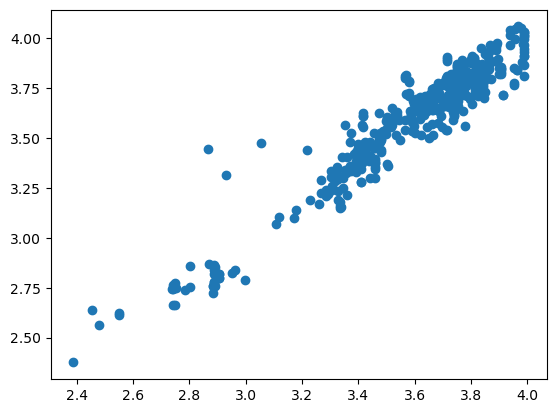

In [14]:
plt.scatter(linear_reg_model(x_data).detach().numpy(),reg.predict(X))

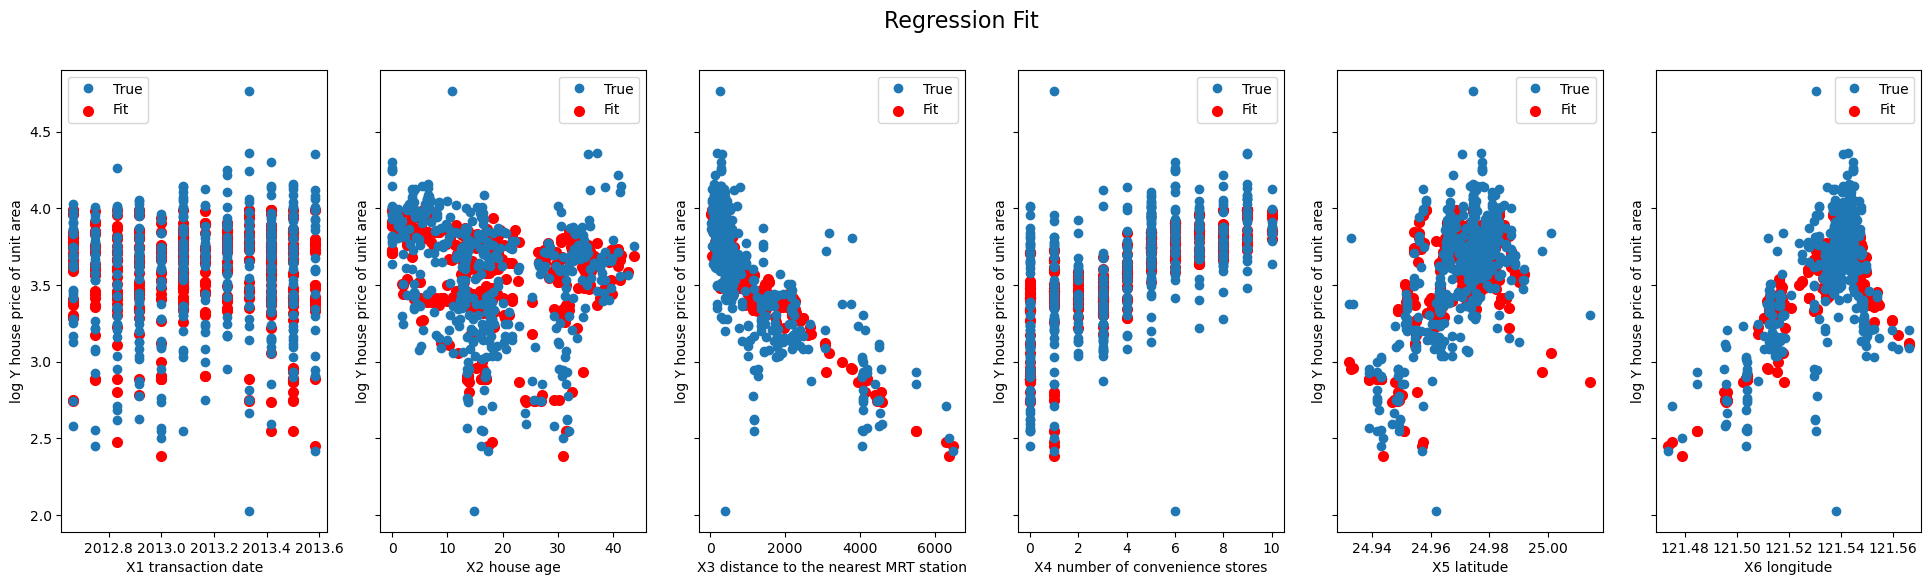

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=len(x_cols), figsize=(4*len(x_cols), 6), sharey=True)
fig.suptitle("Regression Fit", fontsize=16)

for i,col_i in enumerate(x_cols):
    ax[i].plot(real_estate[col_i], np.log(real_estate["Y house price of unit area"]), "o", label = "True")
    ax[i].scatter(real_estate[col_i], fit["mean"], linewidth=2,color="red", label= "Fit")
    ax[i].set(xlabel=col_i,
          ylabel="log Y house price of unit area")
    ax[i].legend()

# ax[1].plot(real_estate['X3 distance to the nearest MRT station'],\
#            np.log(real_estate["Y house price of unit area"]), "o", label = "True")
# ax[1].scatter(real_estate['X3 distance to the nearest MRT station'], fit["mean"], linewidth=2,color="red", label= "Fit")
# ax[1].set(xlabel="X3 distance to the nearest MRT station",
#           ylabel="log Y house price of unit area")
# ax[1].legend()

In [16]:
# plt_predicted = linear_reg_model(torch.tensor(model_viz, dtype=torch.float)).detach().cpu().numpy()

# ax = plt.figure().add_subplot(projection='3d')
# ax.plot(X["X2 house age"], X["X3 distance to the nearest MRT station"],\
#          y, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
# ax.scatter(xx_pred.flatten(), yy_pred.flatten(), plt_predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
# ax.view_init(elev=20, azim=60)
# ax.set_xlabel("X2 house age")
# ax.set_ylabel("X3")
# ax.set_zlabel("log(house price)")

### Bayesian Regression with Pyro's Stochastic Variational Inference (SVI)
AutoDiagonalNormal guide that models the distribution of unobserved parameters in the model as a Gaussian with diagonal covariance, i.e. it assumes that there is no correlation amongst the latent variables

In [56]:
from svi_diagonal import ashish_bayes_regr_svi
samples,params_df = ashish_bayes_regr_svi(X,y,n_samples=200,NUM_ITER=6000)

Optimising ELBO loss
[iteration 0001] loss: 82585.1113
[iteration 0301] loss: 880.3149
[iteration 0601] loss: 10.6771
[iteration 0901] loss: 76.8660
[iteration 1201] loss: 6.9931
[iteration 1501] loss: 17.6180
[iteration 1801] loss: 182.7668
[iteration 2101] loss: 76.2024
[iteration 2401] loss: 10.3955
[iteration 2701] loss: 28.9123
[iteration 3001] loss: 9.5810
[iteration 3301] loss: 28.9331
[iteration 3601] loss: 36.2068
[iteration 3901] loss: 17.9631
[iteration 4201] loss: 3.9606
[iteration 4501] loss: 45.1270
[iteration 4801] loss: 15.6767
[iteration 5101] loss: 17.8475
[iteration 5401] loss: 2.3552
[iteration 5701] loss: 2.3649
Learned parameters:
AutoDiagonalNormal.loc Parameter containing:
tensor([ 2.7128,  0.0031, -0.0070, -0.0056,  0.0300,  0.0086, -0.0255, -0.2665],
       requires_grad=True)
AutoDiagonalNormal.scale tensor([0.0768, 0.0012, 0.0158, 0.0016, 0.0262, 0.0149, 0.0060, 0.0338],
       grad_fn=<SoftplusBackward0>)
Quantiles for params
{'sigma': tensor([1.8694, 1.875

#### Density of Posterior params

Text(0.5, 0.98, 'Posterior Density of Regression parameters')

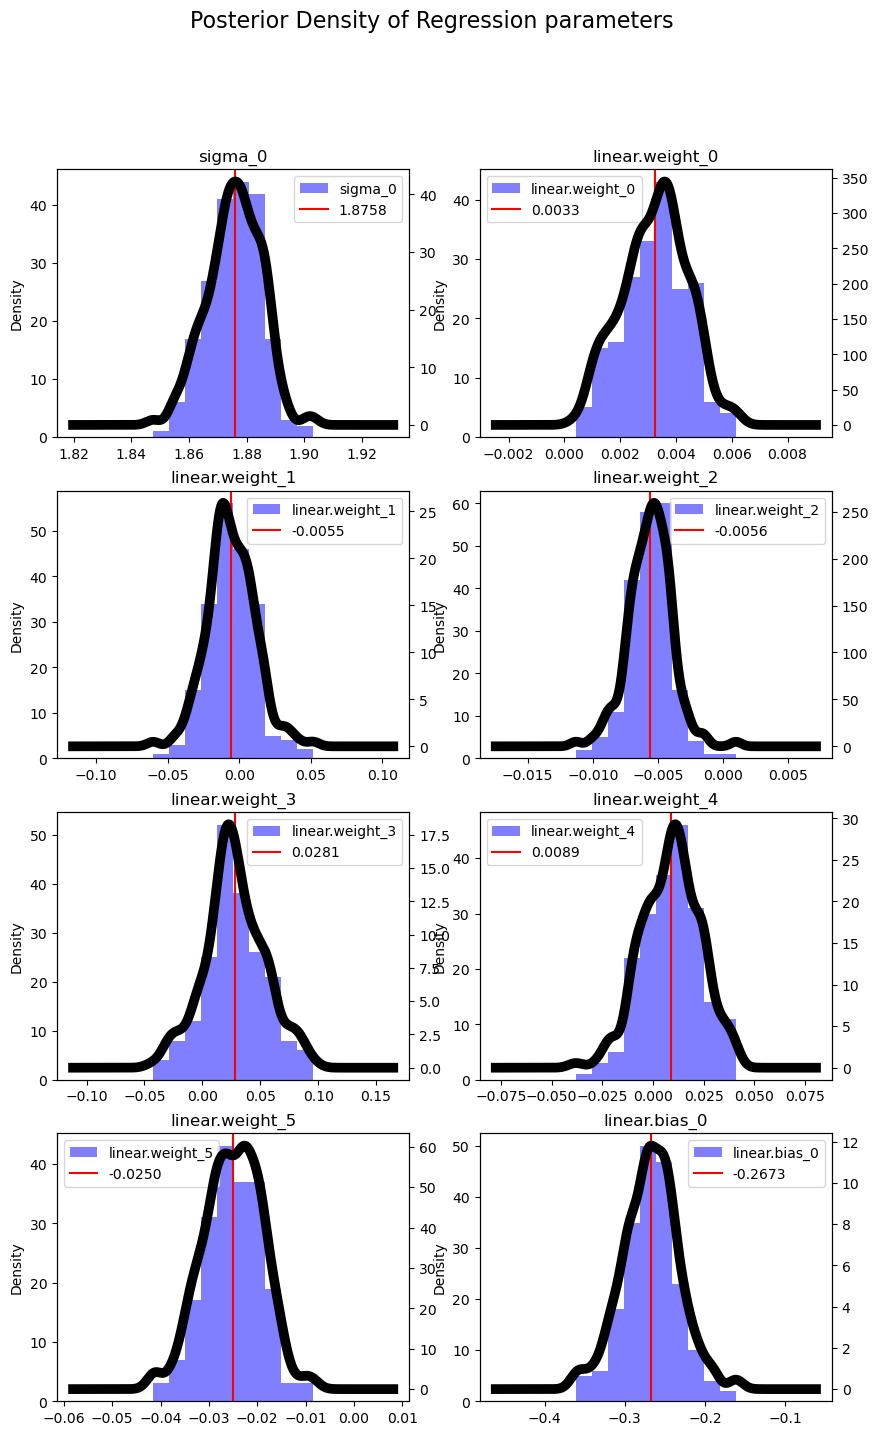

In [57]:
fig,ax = plt.subplots(4,2,figsize=(10,4*4))
for i,param in enumerate(params_df.columns):
    ax_i = ax.reshape(-1)[i]
    params_df[param].plot.hist(ax=ax_i,color="blue",alpha=0.5)
    params_df[param].plot.kde(ax=ax_i,secondary_y=True,lw=7,color="black",bw_method=0.25)
    param_mean = params_df[param].mean()
    ax_i.axvline(param_mean,label=f"{param_mean:.4f}",color="red")
    ax_i.set_title(param)
    ax_i.legend()
    
fig.suptitle("Posterior Density of Regression parameters", fontsize=16)

#### Regression CI

In [58]:
def summary_np(samples):
    site_stats = {}
    for k, v in samples.items():
        v_np = v.numpy()
        site_stats[k] = {
            "mean": v_np.mean(axis=0),
            "std": v_np.std(axis=0),
            "25%": np.quantile(v_np,0.25,axis=0),
            "75%": np.quantile(v_np,0.75,axis=0),
        }
    return site_stats

pred_summary = summary_np(samples)

In [59]:
# def summary(samples):
#     site_stats = {}
#     for k, v in samples.items():
#         site_stats[k] = {
#             "mean": torch.mean(v, 0),
#             "std": torch.std(v, 0),
#             "1%": v.kthvalue(int(len(v) * 0.01), dim=0)[0],
#             "99%": v.kthvalue(int(len(v) * 0.99), dim=0)[0],
#         }
#     return site_stats

# pred_summary = summary(samples)

In [60]:
mu = pred_summary["_RETURN"]
y_hat = pred_summary["obs"]
predictions = pd.DataFrame({
    X.columns[0]: x_data[:, 0],
    X.columns[1]: x_data[:, 1],
    X.columns[2]: x_data[:, 2],
    X.columns[3]: x_data[:, 3],
    X.columns[4]: x_data[:, 4],
    X.columns[5]: x_data[:, 5],
    "mu_mean": mu["mean"],
    "mu_perc_25": mu["25%"],
    "mu_perc_75": mu["75%"],
    "y_mean": y_hat["mean"],
    "y_perc_25": y_hat["25%"],
    "y_perc_75": y_hat["75%"],
    "log(house price)": y_data,
})

In [61]:
predictions

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,mu_mean,mu_perc_25,mu_perc_75,y_mean,y_perc_25,y_perc_75,log(house price)
0,2012.916626,32.000000,84.878822,10.0,24.982981,121.540237,3.088691,1.327440,4.845002,3.137815,1.126387,5.144287,3.634951
1,2012.916626,19.500000,306.594696,9.0,24.980339,121.539513,1.885876,0.325604,3.684984,1.807957,-0.545652,4.215821,3.742420
2,2013.583374,13.300000,561.984497,5.0,24.987459,121.543907,0.377612,-1.404359,2.033890,0.548746,-1.479776,2.698604,3.856510
3,2013.500000,13.300000,561.984497,5.0,24.987459,121.543907,0.377341,-1.404559,2.033542,0.475448,-1.744629,2.919810,4.003690
4,2012.833374,5.000000,390.568390,5.0,24.979370,121.542450,1.381848,-0.181847,3.132094,1.230684,-0.858458,3.551025,3.763523
...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,2013.000000,13.700000,4082.014893,0.0,24.941549,121.503807,-19.504671,-24.098604,-14.663566,-19.300140,-24.159041,-14.643819,2.734368
410,2012.666626,5.600000,90.456062,9.0,24.974331,121.543098,3.173109,1.515340,4.846487,3.255038,1.137853,5.356650,3.912023
411,2013.250000,18.799999,390.969604,7.0,24.979231,121.539864,1.361507,-0.266041,3.130967,1.235325,-1.121608,3.697244,3.703768
412,2013.000000,8.100000,104.810097,5.0,24.966740,121.540672,2.967706,1.377411,4.613856,3.300545,1.236354,5.487385,3.960813


Text(0, 0.5, 'y_mean')

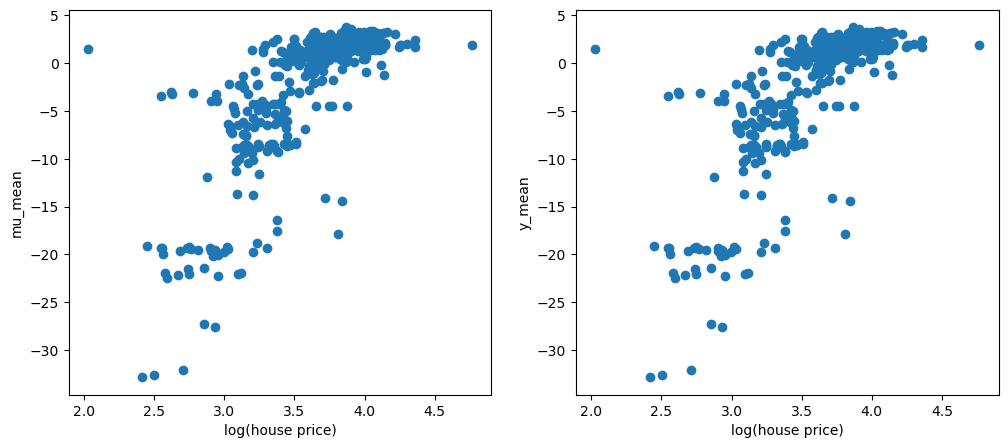

In [62]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(predictions["log(house price)"],predictions["y_mean"])
plt.xlabel("log(house price)")
plt.ylabel("mu_mean")
plt.subplot(122)
plt.scatter(predictions["log(house price)"],predictions["y_mean"])
plt.xlabel("log(house price)")
plt.ylabel("y_mean")

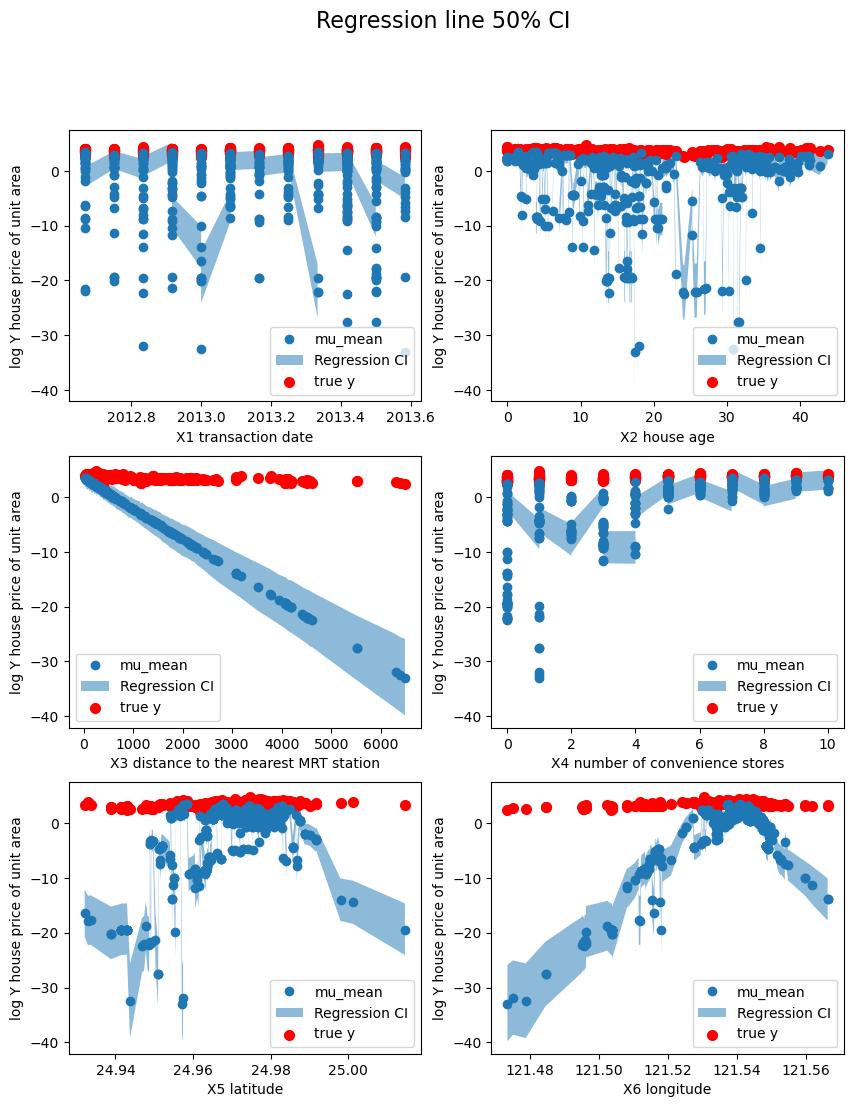

In [70]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 4*3))
fig.suptitle("Regression Fit", fontsize=16)

fig.suptitle("Regression line 50% CI", fontsize=16)
for i,col_i in enumerate(x_cols):
    ax_i=ax.reshape(-1)[i]
    predictions_i = predictions.sort_values(by=col_i)
    ax_i.plot(predictions_i[col_i], predictions_i["mu_mean"], "o", label = "mu_mean")
    ax_i.fill_between(predictions_i[col_i],
                   predictions_i["mu_perc_25"],
                   predictions_i["mu_perc_75"],
                   alpha=0.5,label="Regression CI")
    ax_i.scatter(predictions_i[col_i], predictions_i["log(house price)"], linewidth=2,color="red", label= "true y")
    ax_i.set(xlabel=col_i,
          ylabel="log Y house price of unit area")
    ax_i.legend()

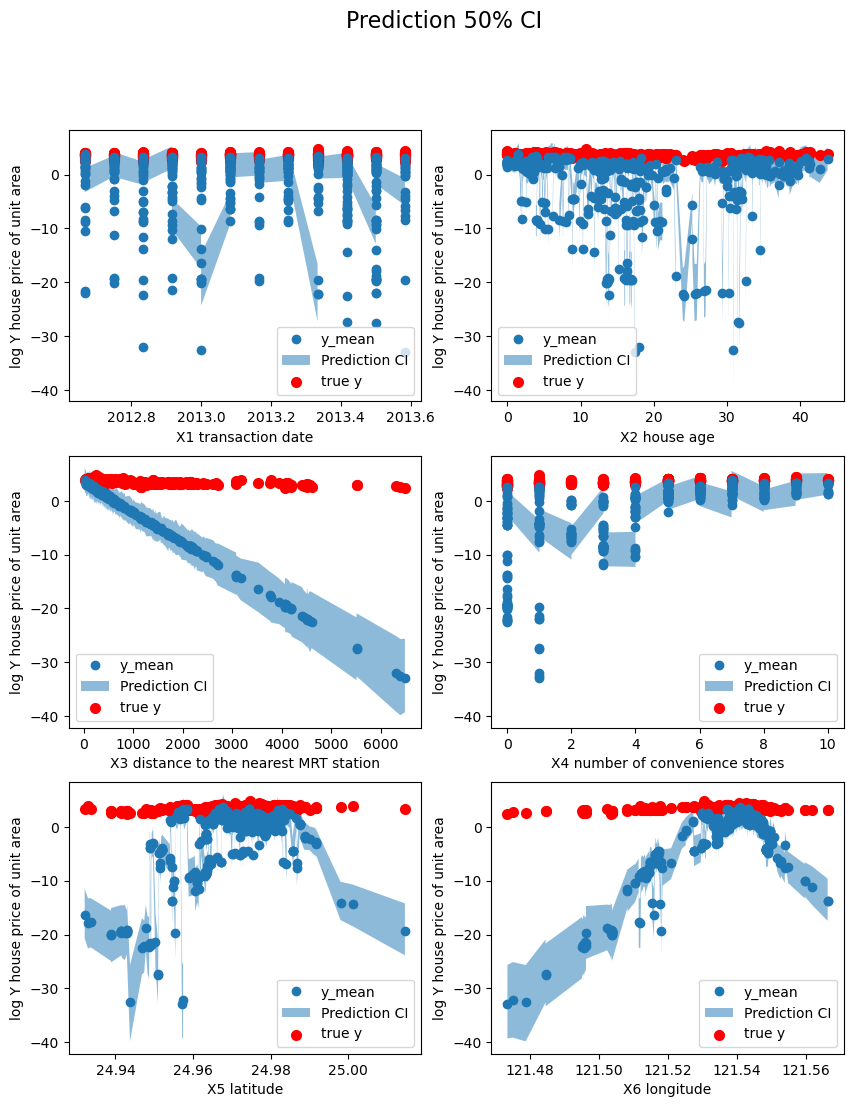

In [72]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 4*3))
fig.suptitle("Regression Fit", fontsize=16)

fig.suptitle("Prediction 50% CI", fontsize=16)
for i,col_i in enumerate(x_cols):
    ax_i=ax.reshape(-1)[i]
    predictions_i = predictions.sort_values(by=col_i)
    ax_i.plot(predictions_i[col_i], predictions_i["y_mean"], "o", label = "y_mean")
    ax_i.fill_between(predictions_i[col_i],
                   predictions_i["y_perc_25"],
                   predictions_i["y_perc_75"],
                   alpha=0.5,label="Prediction CI")
    ax_i.scatter(predictions_i[col_i], predictions_i["log(house price)"], linewidth=2,color="red", label= "true y")
    ax_i.set(xlabel=col_i,
          ylabel="log Y house price of unit area")
    ax_i.legend()

In [65]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

# fig.suptitle("Regression line 50% CI", fontsize=16)
# ax[0].plot(predictions["X2 house age"],
#            predictions["mu_mean"],"o",label="mu_mean")
# ax[0].fill_between(predictions["X2 house age"],
#                    predictions["mu_perc_25"],
#                    predictions["mu_perc_75"],
#                    alpha=0.5,step="pre",interpolate=True,label="Regression CI")

# ax[0].plot(predictions["X2 house age"], 
#            predictions["log(house price)"],"o",label="true y")

# ax[0].set(xlabel="X2 house age",
#           ylabel="log(house price)")
# ax[0].legend()

# ax[1].plot(predictions["X3 distance to the nearest MRT station"],
#            predictions["mu_mean"],"o",label="mu_mean")
# ax[1].fill_between(predictions["X3 distance to the nearest MRT station"],
#                    predictions["mu_perc_25"],
#                    predictions["mu_perc_75"],
#                    alpha=0.5,step="pre",interpolate=True,label="Regression CI")

# ax[1].plot(predictions["X3 distance to the nearest MRT station"], 
#            predictions["log(house price)"],"o",label="true y")

# ax[1].set(xlabel="X3 distance to the nearest MRT station",
#           ylabel="log(house price)")
# ax[1].legend()

In [66]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
# fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)



# ax[0].plot(predictions["X2 house age"],
#            predictions["y_mean"],"o",label="y_mean")
# ax[0].fill_between(predictions["X2 house age"],
#                    predictions["y_perc_25"],
#                    predictions["y_perc_75"],
#                    alpha=0.5,step="pre",interpolate=True,label="Prediction CI")

# ax[0].plot(predictions["X2 house age"], 
#            predictions["log(house price)"],"o",label="true y")

# ax[0].set(xlabel="X2 house age",
#           ylabel="log(house price)")
# ax[0].legend()

# ax[1].plot(predictions["X3 distance to the nearest MRT station"],
#            predictions["y_mean"],"o",label="y_mean")
# ax[1].fill_between(predictions["X3 distance to the nearest MRT station"],
#                    predictions["y_perc_25"],
#                    predictions["y_perc_75"],
#                    alpha=0.5,step="pre",interpolate=True,label="Prediction CI")

# ax[1].plot(predictions["X3 distance to the nearest MRT station"], 
#            predictions["log(house price)"],"o",label="true y")

# ax[1].set(xlabel="X3 distance to the nearest MRT station",
#           ylabel="log(house price)")
# ax[1].legend()

In [67]:
predictions.to_csv("./svi_diagonal_output/predictions_svi_diagonal_6cols.csv",index=None)

In [68]:
# predictions["X2 house age"].plot()